# Sequential Load forecasting with Timeseries transformer model

#Setup

In [ ]:
import scipy.io as sio
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import random
from keras.layers import Dense
from keras.layers import GRU
from tensorflow.python.keras import backend as K
from keras.layers import Dropout, Add
import os
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import math
random.seed(322)

# Chemical industry Energy Consumption Dataset
The dataset contains attributes related to Electricity consumption and actual load.

In [ ]:
# Google drive로 Mount

from google.colab import drive
drive.mount('/content/drive/')
# 폴더 이동
%cd '/content/drive/My Drive/hanhwa_AA/Hanhwa_AA/2_Load_forecast/Transformer/' #수정필요



df = pd.read_csv('Load7.csv')
display(df)

,utc_timestamp,consumption,DK_2_load_actual_tso
0,2008-01-01T00:00:00Z,1468.0,1499.4
1,2008-01-01T01:00:00Z,1400.2,1439.4
2,2008-01-01T02:00:00Z,1334.8,1372.0
3,2008-01-01T03:00:00Z,1290.1,1324.9
4,2008-01-01T04:00:00Z,1286.1,1314.4
...,...,...,...
29994,2011-06-03T18:00:00Z,1330.1,1370.1
29995,2011-06-03T19:00:00Z,1285.6,1326.4
29996,2011-06-03T20:00:00Z,1279.5,1322.2
29997,2011-06-03T21:00:00Z,1200.4,1233.1


# We select the consumption data as our target variable.

In [ ]:
columns_to_use = ['consumption']
df = df[columns_to_use]
display(df)

,consumption
0,1468.0
1,1400.2
2,1334.8
3,1290.1
4,1286.1
...,...
29994,1330.1
29995,1285.6
29996,1279.5
29997,1200.4


In [ ]:
#Plot Output variable
%matplotlib qt5
plt.figure(figsize=(5, 5))
plt.plot(df['consumption'], 'k-', label='Us')
plt.xlabel('Samples (Hour)', fontsize=12)
plt.ylabel('Load (kWh)', fontsize=12)
plt.grid(True)
plt.tight_layout()


In [ ]:
#Data Normalization

max = df.max()
df = (df / df.max())
print('Top 10 of Dataframe:', df.head(10))
print('Maximum:', max)

Top 10 of Dataframe:    consumption
0     0.560412
1     0.534529
2     0.509563
3     0.492499
4     0.490972
5     0.501050
6     0.514717
7     0.525482
8     0.551136
9     0.586104
Maximum: consumption    2619.5
dtype: float64


# Transform the univariate data into past and future sequences using a sliding window.

In [ ]:
#Sliding window parameters and function
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
#Past 12 hours to predict a sequence of next 4 hours.
past_datapoints = 12
future_datapoints = 4

In [ ]:
#Using first 20000 samples of the datset to reduce training time.
X, y = split_sequences(np.array(df), past_datapoints, future_datapoints)
X=X[0:20000,:,0:1]
y = y[0:20000, :, 0:1]
X = X.reshape(*X.shape[:])
y = y.reshape(y.shape[0], y.shape[1] * y.shape[2])
print('X-shape:', X.shape, 'y-shape:', y.shape)

X-shape: (20000, 12, 1) y-shape: (20000, 4)


In [ ]:
#Dividing data into train, validate and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
X_train,X_valid, y_train , y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=False)
print('X_train-shape:', X_train.shape, 'y_train-shape:', y_train.shape)
print('X_valid-shape:', X_valid.shape, 'y_train-shape:', y_valid.shape)
print('X_test-shape:', X_test.shape, 'y_test-shape:', y_test.shape)

X_train-shape: (12800, 12, 1) y_train-shape: (12800, 4)
X_valid-shape: (3200, 12, 1) y_train-shape: (3200, 4)
X_test-shape: (4000, 12, 1) y_test-shape: (4000, 4)


# Multi-head self attention

In [ ]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)

    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape


class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)

    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=[2, 2]) / self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x: (-1e+10) * (1 - x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn


class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=1, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head * d_k, use_bias=False)
            self.ks_layer = Dense(n_head * d_k, use_bias=False)
            self.vs_layer = Dense(n_head * d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)  # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x

            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x: K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)

            def reshape2(x):
                s = tf.shape(x)  # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]])
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head * d_v])  # [batch_size, len_v, n_head * d_v]
                return x

            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = [];
            attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)
                ks = self.ks_layers[i](k)
                vs = self.vs_layers[i](v)
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head);
                attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

# Callbacks for training

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.0009
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []

    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-3, mode='auto')
callbacks_list = [loss_history, reduce_lr_loss]

# Transformer model compilation

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 12, 128)      25344       input_3[0][0]                    
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 12, 64)       8192        bidirectional_4[0][0]            
__________________________________________________________________________________________________
time_distributed_21 (TimeDistri (None, 12, 64)       8192        bidirectional_4[0][0]            
____________________________________________________________________________________________

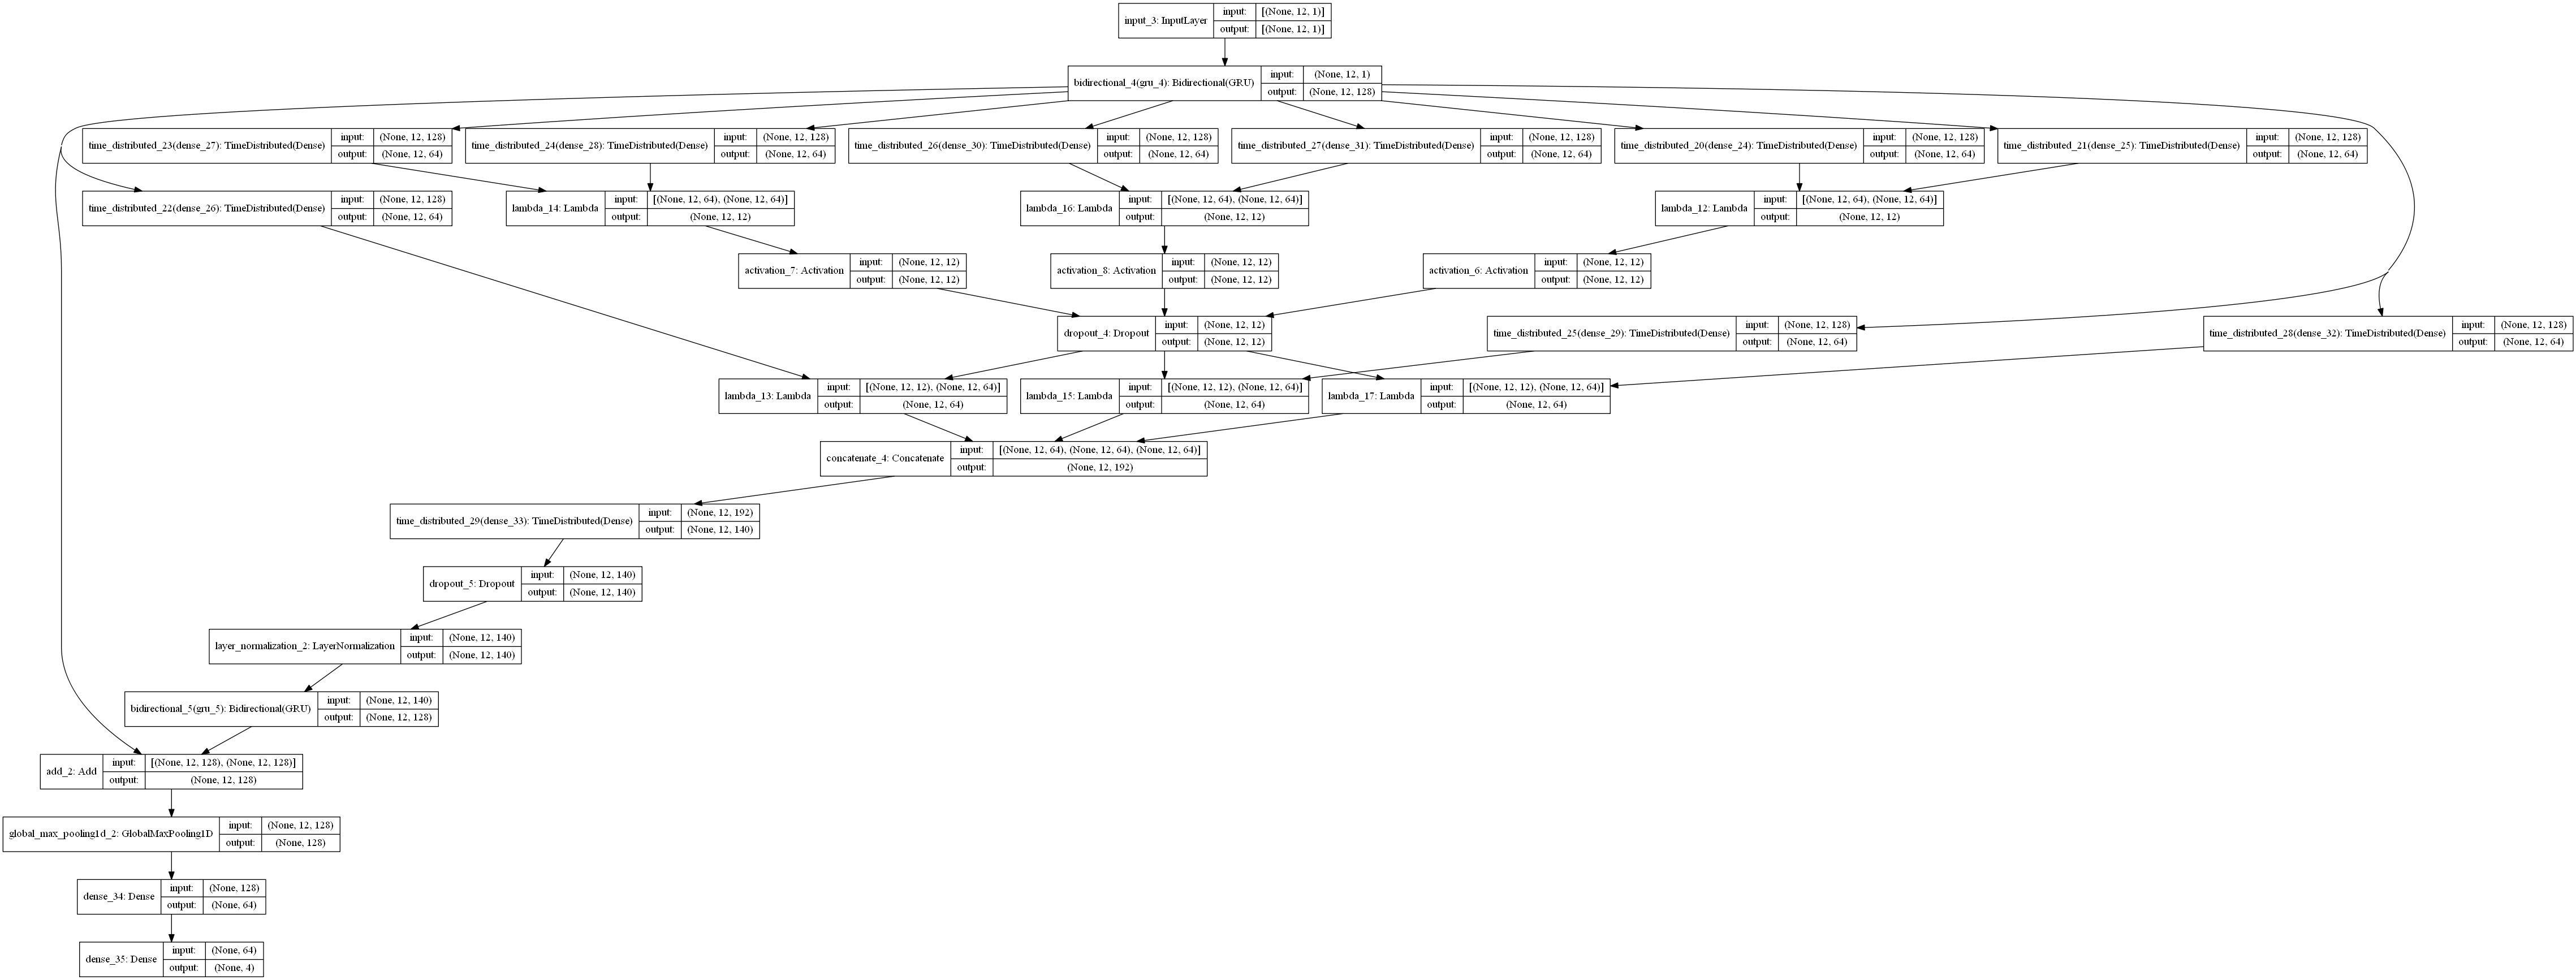

In [ ]:
def build_model():
    inp = Input(shape=(past_datapoints, X_train.shape[2]))
    encoder = Bidirectional(GRU(64, return_sequences=True, activation = 'relu'))(inp)
    decoder, slf_attn = MultiHeadAttention(n_head=3, d_model=140, d_k=64, d_v=64, dropout=0.30)(encoder,encoder, encoder)
    decoder = Bidirectional(GRU(64, return_sequences=True,activation='relu'))(decoder)
    z = Add()([encoder,decoder])
    z = GlobalMaxPooling1D()(z)
    z = Dense(64, activation="relu")(z)
    x = Dense(future_datapoints, activation="linear")(z)

    model = Model(inputs=inp, outputs=x)
    opt = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(
        loss="mean_squared_error",
        optimizer=opt)
    return model
Timeseries_transformer = build_model()
Timeseries_transformer.summary()
keras.utils.plot_model(Timeseries_transformer,"model_summary.png",show_shapes=True)

## Model training and parameters.

In [ ]:
embed_size = 60
Train = 1
EPOCHS = 100  # how many passes through our data
BATCH_SIZE = 100
if Train==1:
    history=Timeseries_transformer.fit(X_train,
                        y_train,
                        batch_size=int(BATCH_SIZE),
                        epochs=int(EPOCHS),
                        verbose=1,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks_list)
    Timeseries_transformer.save_weights("/Transformer.h5")
else:
    Timeseries_transformer.load_weights("/Transformer.h5")


Train on 12800 samples, validate on 3200 samples
Epoch 1/100
 2700/12800 [=====>........................] - ETA: 26s - loss: 0.2627 

In [ ]:
pred_test = Timeseries_transformer.predict(X_test)
y_pred = pred_test*max[0]
y_test1 = y_test*max[0]

In [ ]:
from itertools import chain
def make_linear(y_pred_951,future_datapoints):
    lin1 = np.asmatrix(y_pred_951)
    factor2 = len(lin1)
    lowerloop2 = round((factor2/future_datapoints))
    lin2 = []
    for i in range (lowerloop2):
            holder2 = lin1[:][i*future_datapoints]
            lin2.append(holder2.tolist()[0])

    lin3 = list(chain.from_iterable(lin2))
    lin3 = np.array(lin3)
    return lin3
linear_test = make_linear(y_test1,future_datapoints)
linear_pred = make_linear(y_pred,future_datapoints)

In [ ]:
%matplotlib qt5
plt.figure(figsize=(5, 5))
plt.plot(linear_test, 'k-', label='Test data')
plt.plot(linear_pred, 'b-', label='predicted data')
plt.title('4-hour ahead Load requirement', fontsize=12)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Test samples (01 hour)', fontsize=12)
plt.ylabel('Load (kWh)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.xlim([2290, 2890])
plt.show()